# Assignment 3 Primer

* Assignment 3 will be based on a sample of movie rating predictions from the Netflix Prize dataset.
* It includes two pregenerated splits of 10k users for about 3k movies. So there is already a train and validation split that you will use for your experiments.
* It can be a little tricky to use predefined splits in surpise, so I will show you how to do it here.
* There are many articles available that talk about the million dollar prize and what it meant for the company. A few are:
* https://towardsdatascience.com/deep-dive-into-netflixs-recommender-system-341806ae3b48
* https://www.thrillist.com/entertainment/nation/the-netflix-prize
* https://analyticsindiamag.com/how-useful-was-the-netflix-prize-really/

In [1]:
import numpy as np
import pyarrow.feather as feather
import pandas as pd

# If you are on an Intel-based machine, you can also enable scikit-learn intel optimizations.
# This does not work on an M1 / M2 Macbook, but does on older Macbooks with an Intel.
# Requires ``pip install scikit-learn-intelex''
#
# from sklearnex import patch_sklearn
# patch_sklearn()

In [2]:
import pyarrow.feather as feather
import pandas as pd
from surprise import Dataset, Reader, BaselineOnly, accuracy
from surprise.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from joblib import parallel_backend
from surprise import SVD
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import CoClustering
from surprise import AlgoBase
from surprise import SlopeOne
from surprise import KNNBasic
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from collections import defaultdict
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm
from pandas.plotting import table
import seaborn as sns
import os, psutil

In [3]:
# Reading feather files to dataframe
df_train = feather.read_feather('netflix-5k.train.feather')
df_val = feather.read_feather('netflix-5k.validation.feather')
df_titles = feather.read_feather('netflix-5k.movie_titles.feather')
df_train #321490

,userID,movieID,rating
0,1000596,10036,4.0
1,1000596,10100,2.0
2,1000596,10209,3.0
3,1000596,10212,3.0
4,1000596,10225,3.0
...,...,...,...
1287012,99993,9683,4.0
1287013,99993,9685,4.0
1287014,99993,9800,2.0
1287015,99993,9939,5.0


In [4]:
# creating training set and validation set seperately. 
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_train[['userID','movieID',
                                      'rating']],reader)
datav = Dataset.load_from_df(df_val[['userID','movieID',
                                       'rating']],reader)
trainset = data.build_full_trainset()
NA,valset = train_test_split(datav, test_size=1.0)

In [5]:
# generating anti test set which would be useful while calculating evaluation metrics especially hit rate
def gen_anti_testset_user(valset, target_user):
  anti_testset_user = []
  fill_value = trainset.global_mean
  user_item_ratings = trainset.ur[target_user]
  user_items = [item for (item,_) in (user_item_ratings)]
  ratings = trainset.all_ratings()
  for iid in trainset.all_items():
    if iid not in user_items:
      raw_uid = trainset.to_raw_uid(target_user) 
      raw_iid = trainset.to_raw_iid(iid) 
      anti_testset_user.append((raw_uid,raw_iid,fill_value))
  return anti_testset_user

# running algorithms on anti test set taking 'algo' s parameter in which we would be feeding fitted algorithms with tuning

def algo_on_all_antisets(algo, trainset, valset, all_antisets, progress = False, k = 10):
  scores_dict = {}
  if progress == True:
    print ('Scoring all user antisets and testset.')
    algo.fit(trainset)
    predictions = algo.test(valset)
    rmse = accuracy.rmse(predictions,verbose=False)
    mae = accuracy.mae(predictions,verbose=False)
    fcp = accuracy.fcp(predictions,verbose=False)
    mse = accuracy.mse(predictions,verbose=False)
    topNall = {}
#     we would be appending all the scores of the algorithm in an dictionary
    scores_dict['RMSE'] = round(rmse,3)
    scores_dict['MAE'] = round(mae, 3)
    for u,v in tqdm(all_antisets.items()):
      predictions = algo.test(v)
      pred = pd.DataFrame(predictions)
      p = pred.rename(columns={'uid':'userID','iid':'movieID'})
      pred = p.nlargest(k,['est'],keep='all')
      pred.sort_values('movieID',ascending=True,inplace=True,kind='stable')
      pred.sort_values('est',ascending=False,inplace=True,kind='stable')
      pred['pred_rank'] = pred['est'].rank(ascending=False,
                                           method='first',na_option='bottom')
      pred['pred_rank'] = pred['pred_rank'].astype(int)
      pred.reset_index(inplace=True) 
      pred.drop('index',axis=1,inplace=True)
      pred['estint'] = round(pred['est'])
      pred['estint'] = round(pred['estint'].astype(float),1)
      topNall[u] = pred
#      returning scores and scores stored dictionary
    return topNall,rmse,mae,fcp,mse,scores_dict
  else:
    print ('Scoring all user antisets and testset.')
    algo.fit(trainset)
    predictions = algo.test(valset)
    rmse = accuracy.rmse(predictions,verbose=False)
    mae = accuracy.mae(predictions,verbose=False)
    fce = accuracy.fce(predictions,verbose=False)
    mse = accuracy.mse(predictions,verbose=False)
    topNall = {}
    for u,v in tqdm(all_antisets.items()):
      predictions = algo.test(v)
      pred = pd.DataFrame(predictions)
      p = pred.rename(columns={'iid':'userID','uid':'movieID'})
      pred = p.nlargest(k,['est'],keep='all')
      pred.sort_values('movieID',ascending=True,inplace=True,kind='stable')
      pred.sort_values('est',ascending=False,inplace=True,kind='stable')
      pred['pred_rank'] = pred['est'].rank(ascending=False,
                                           method='first',na_option='bottom')
      pred['pred_rank'] = pred['pred_rank'].astype(int)
      pred.reset_index(inplace=True) 
      pred.drop('index',axis=1,inplace=True)
      pred['estint'] = round(pred['est'])
      pred['estint'] = round(pred['estint'].astype(float),1)
      topNall[u] = pred
    return topNall,rmse,mae,fcp,mse,scores_dict



In [6]:
def gen_r2i_map(trainset):
  inner2raw_uid = {}
  raw2inner_uid = {}
  inner2raw_iid = {}
  raw2inner_iid = {}
  for uid in tqdm(trainset.all_users()):
    rawid = trainset.to_raw_uid(uid)
    inner2raw_uid[uid] = rawid
    raw2inner_uid[rawid] = uid
  for iid in tqdm(trainset.all_items()):
    rawid = trainset.to_raw_iid(iid)
    inner2raw_iid[iid] = rawid
    raw2inner_iid[rawid] = iid
  return inner2raw_uid, raw2inner_uid,inner2raw_iid,raw2inner_iid
#  generating reference sets. 
def gen_reference_sets(tdf, i2r_uid, r2i_iid, progress=False,k=10):
  ref = {}
  for u in i2r_uid.keys():
    udf = tdf[tdf['userID'] == i2r_uid[u]]
    ndf = udf.nlargest(k,['rating'],keep='all')
    ndf.sort_values('movieID',ascending=True,inplace=True,kind='stable')
    ndf.sort_values('rating',ascending=False,inplace=True,kind='stable')
    ndf['ref_rank'] = ndf['rating'].rank(ascending=False,method='first',
                                         na_option='bottom')
    ndf['ref_rank'] = ndf['ref_rank'].astype(int)
    ndf.reset_index(inplace=True) 
    ndf.drop('index',axis=1,inplace=True) 
    ref[u] = ndf 
  return ref

def gen_antisets(trainset,progress=False):
  all_antisets = {}
  if progress == True:
    print ('Generating antiset for each user.')
    for uid in tqdm(trainset.all_users()):
      antitsu = gen_anti_testset_user(trainset, uid)
      all_antisets[uid] = antitsu
  else:
    for uid in trainset.all_users():
      antitsu = gen_anti_testset_user(trainset, uid)
      all_antisets[uid] = antitsu
  return all_antisets


In [7]:
i2r_uid, r2i_uid, i2r_iid, r2i_iid = gen_r2i_map(trainset)


100%|██████████| 4334/4334 [00:00<00:00, 1079140.01it/s]


In [8]:
ref = gen_reference_sets(df_val, i2r_uid,r2i_iid, progress=False, k=10)
all_antisets = gen_antisets(trainset)

# Data Analysis

In [9]:
# taking some stats to better select algorithms and converting to a df. 
z = (df_train.describe()['rating'].T).to_frame()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
z

,rating
count,1287017.000
mean,3.610
std,1.045
min,1.000
25%,3.000
50%,4.000
75%,4.000
max,5.000


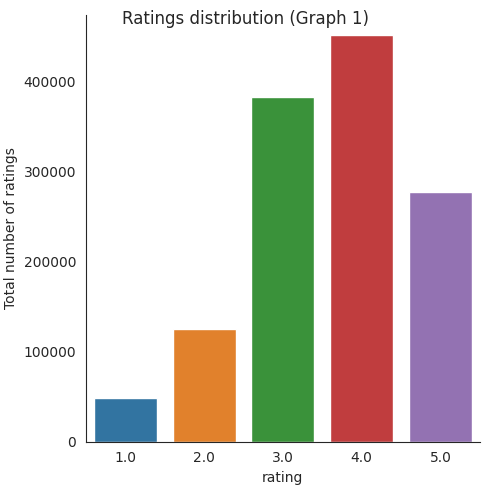

In [10]:
# making graph for the analyzing count of users for each rating 
with sns.axes_style('white'):
    g = sns. catplot (data=df_train, x='rating', kind='count')
    g.set_ylabels("Total number of ratings")
    g.fig.suptitle("Ratings distribution (Graph 1)")

In [11]:
display(df_titles)

,movieID,imdb_id,imdb_date,date,title,genre
0,3,1860,1997,1997,Character,Drama
1,8,27899,2004,2004,What the #$*! Do We Know!?,Comedy|Documentary|Drama
2,16,76,1995,1996,Screamers,Action|Sci-Fi|Thriller
3,18,249,1994,1994,Immortal Beloved,Drama|Romance
4,26,7368,2004,2004,Never Die Alone,Crime|Drama|Thriller
...,...,...,...,...,...,...
4329,17761,6285,2003,2003,Levity,Drama
4330,17762,1653,1997,1997,Gattaca,Drama|Sci-Fi|Thriller
4331,17763,3813,1978,1978,Interiors,Drama
4332,17764,2396,1998,1998,Shakespeare in Love,Comedy|Drama|Romance


In [12]:
# display(df_train)
((df_train.merge(df_titles, on='movieID')))

,userID,movieID,rating,imdb_id,imdb_date,date,title,genre
0,1000596,10036,4.000,172343,2004,2004,Chris Rock: Never Scared,Comedy
1,1047019,10036,5.000,172343,2004,2004,Chris Rock: Never Scared,Comedy
2,1066990,10036,4.000,172343,2004,2004,Chris Rock: Never Scared,Comedy
3,1080891,10036,4.000,172343,2004,2004,Chris Rock: Never Scared,Comedy
4,108717,10036,5.000,172343,2004,2004,Chris Rock: Never Scared,Comedy
...,...,...,...,...,...,...,...,...
1287012,611692,17379,3.000,4956,1980,1980,The Stunt Man,Action|Adventure|Comedy|Drama|Romance|Thriller
1287013,659882,17379,4.000,4956,1980,1980,The Stunt Man,Action|Adventure|Comedy|Drama|Romance|Thriller
1287014,668042,17379,3.000,4956,1980,1980,The Stunt Man,Action|Adventure|Comedy|Drama|Romance|Thriller
1287015,798142,17379,3.000,4956,1980,1980,The Stunt Man,Action|Adventure|Comedy|Drama|Romance|Thriller


## Now let's look at the API documents for the 'baseline' only model in surprise: https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration

## Or after some digging, even more informative -- https://github.com/NicolasHug/Surprise/blob/master/doc/source/prediction_algorithms.rst

## Note that while my attempt to tune the BaselineOnly method did not result in any noticeable performance improvements based on RMSE, that is not entirely surprising based on how this algorithm works. My goal was to show you how to tune the parameters using two different methods, so that you could more easily test and tune other algorithms from surprise.

In [14]:
# Print the memory usage of this process. Requires you to set n_jobs=1 and ``pip install psutil''
# Use this to debug any memory issues you might be having.
process = psutil.Process(os.getpid())
print(process.memory_info().rss/(1024*1024))  # in MB

467.6953125


In [15]:
# converting predictions maade by models to df and appending an error column 'err' to the df
def predictions_to_df(p):
  df = pd.DataFrame(p, columns=['uid', 'iid', 'rui', 'est', 'details'])
# taking difference of estimated and predicted value to calculate error 
  df['err'] = abs(df['rui'] - df['est'])
  return df

# Algorithm 1: SVD

In [16]:
# Best parameters for SVD are {'n_epochs': 35, 'biased': 'False', 'n_factors': 50, 'reg_all': 0.055, 'lr_all': 0.007, 'init_std_dev': 0.03, 'init_mean': 0.125}
# calling svd along with its appropriate optimised parameters which I found out in seperate file through RandomisedSearchCV
svd_tuned = SVD(n_factors = 225, n_epochs = 110, biased = False, init_std_dev = 0.2, lr_all = 0.005, reg_all = 0.055, init_mean = 0.25) #Best parameters for SVD are n_epochs = 40, reg_all = 0.06, lr_all = 0.07
# fitting traindata into above called algorithm
fitted_svd = svd_tuned.fit(trainset)
# making prediction with fitted model
predictions_svd = fitted_svd.test(valset)
print('RMSE for SVD = {}'.format(round(accuracy.rmse(predictions_svd,verbose=False),3)))

RMSE for SVD = 0.834


# Algorithm 2: KNNBasic

In [17]:
# Best Score from Grid Search is  0.8566224546930907
# Best parameters for sim options are {'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'shrinkage': 120}}
# calling KNN Basic along with its appropriate optimised parameters which I found out in seperate file through RandomisedSearchCV
sim_options = {'name': 'pearson_baseline', 'user_based': False, 'shrinkage': 150, 'min_support': 2}
knn_basic = KNNBasic(sim_options = sim_options, min_k = 1, k = 40)
# fitting traindata into above called algorithm
fitted_knn_basic = knn_basic.fit(trainset)
# making prediction with fitted model
predictions_with_knn_basic = fitted_knn_basic.test(valset)
print('RMSE for KNN Basic = {}'.format(round(accuracy.rmse(predictions_with_knn_basic,verbose=False),3)))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE for KNN Basic = 0.888


# Algorithm 3: CoClustering

In [18]:
# Best Score from Grid Search is  0.8849491697508329
# Best parameters for SVD are {'n_epochs': 30, 'n_cltr_u': 7, n_cltr_i: 9}
# calling Co Clustering along with its appropriate optimised parameters which I found out in seperate file through RandomisedSearchCV
coClustering = CoClustering(n_epochs=35, n_cltr_u = 7, n_cltr_i = 9 )
# fitting traindata into above called algorithm
fitted_coClustering = coClustering.fit(trainset)
# making prediction with fitted model
predictions_with_coClustering = fitted_coClustering.test(valset)
print('RMSE for Co-Clustering = {}'.format(round(accuracy.rmse(predictions_with_coClustering,verbose=False),3)))

RMSE for Co-Clustering = 0.878


# Algorithm 4: SlopeOne

In [19]:
# calling slope one
slope_one = SlopeOne()
# fitting traindata into above called algorithm
fitted_slope_one = slope_one.fit(trainset)
predictions_with_slope_one = fitted_slope_one.test(valset)
# making prediction with fitted model
# Without Tuning: RMSE = 0.895
print('RMSE for Slope One = {}'.format(round(accuracy.rmse(predictions_with_slope_one,verbose=False),3)))

RMSE for Slope One = 0.895


# Evaluation

In [20]:
# this function runs fitted algorithm which is algorithm 'algo' in parameter and then calculated hit rate and appends to scores dictionary
def showMetrics(algo, trainset, valset, all_antisets):
    algo_on_all_antiset = algo_on_all_antisets(algo,trainset,valset,
                                                  all_antisets,
                                                  progress=True, k=10)
    topNall = algo_on_all_antiset[0]
    scores_dict = algo_on_all_antiset[5]
    hr = HitRate(topNall,ref)
    scores_dict['HitRate'] = round(hr,3)
    return scores_dict
#     print('HitRate for {} is {}'.format(algo, hr))


In [21]:
# calculating hit rate 
def HitRate(topNPredicted, refSet):
  hits = 0
  total = 0
  print('Computing Hitrate') 
  for k,v in topNPredicted.items():
    ref = refSet[k]
    total += len(v.index)
    all_df = pd.merge(v,ref, on=['userID','movieID'])
    hits += len(all_df.index)
  return float(hits)/float(total)

In [22]:
# calculating each metric for tuned SVD in parameter 
scores_svd = showMetrics(svd_tuned, trainset, valset, all_antisets)
print('Scores for SVD: ', scores_svd)
# Output: {'RMSE': 0.834, 'MAE': 0.655, 'HitRate': 0.08}

Scoring all user antisets and testset.


100%|██████████| 5000/5000 [04:03<00:00, 20.56it/s]


Computing Hitrate
Scores for SVD:  {'RMSE': 0.834, 'MAE': 0.655, 'HitRate': 0.079}


In [23]:
# calculating each metric for tuned KNN Basic in parameter 
scores_knn_basic = showMetrics(knn_basic, trainset, valset, all_antisets)
print('Scores for KNN Basic: ', scores_knn_basic)
# Output: {'RMSE': 0.888, 'MAE': 0.696, 'HitRate': 0.068}

Scoring all user antisets and testset.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


100%|██████████| 5000/5000 [45:20<00:00,  1.84it/s]  


Computing Hitrate
Scores for KNN Basic:  {'RMSE': 0.888, 'MAE': 0.696, 'HitRate': 0.068}


In [24]:
# calculating each metric for tuned Co Clustering in parameter 
scores_co_clustering = showMetrics(coClustering, trainset, valset, all_antisets)
print('Scores for Co-Clustering: ', scores_co_clustering)

Scoring all user antisets and testset.


100%|██████████| 5000/5000 [03:49<00:00, 21.83it/s]


Computing Hitrate
Scores for Co-Clustering:  {'RMSE': 0.879, 'MAE': 0.688, 'HitRate': 0.041}


In [25]:
# calculating each metric for tuned Slope One in parameter 
scores_slope_one = showMetrics(slope_one, trainset, valset, all_antisets)
print('Scores for Slope One: ', scores_slope_one)

Scoring all user antisets and testset.


100%|██████████| 5000/5000 [30:30<00:00,  2.73it/s]  


Computing Hitrate
Scores for Slope One:  {'RMSE': 0.895, 'MAE': 0.703, 'HitRate': 0.016}


In [26]:
# converting scores for all the algorithms into a df
overall_scores = pd.DataFrame.from_dict([scores_svd, scores_knn_basic, scores_co_clustering, scores_slope_one])
s = pd.Series(['SVD', 'KNNBasic', 'Co-Clustering', 'SlopeOne'])
overall_scores = overall_scores.set_index([s])
overall_scores.sort_values(by=['RMSE'])

,RMSE,MAE,HitRate
SVD,0.834,0.655,0.079
Co-Clustering,0.879,0.688,0.041
KNNBasic,0.888,0.696,0.068
SlopeOne,0.895,0.703,0.016


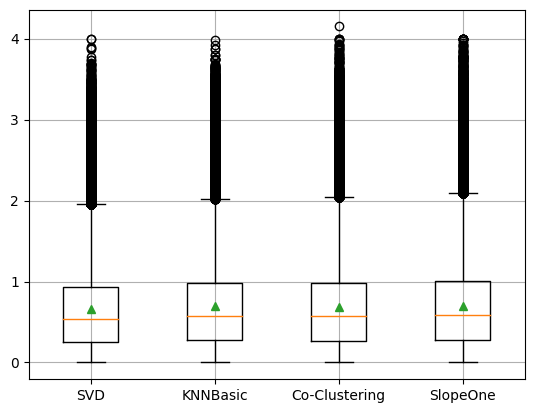

In [28]:
# Doing an error analysis with help of box plot for each algorithm
plt.grid(visible=True, which='major', axis='both')
results = [predictions_to_df(predictions_svd)['err'], predictions_to_df(predictions_with_knn_basic)['err'], predictions_to_df(predictions_with_coClustering)['err'], predictions_to_df(predictions_with_slope_one)['err']]
names = ['SVD', 'KNNBasic', 'Co-Clustering', 'SlopeOne']
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

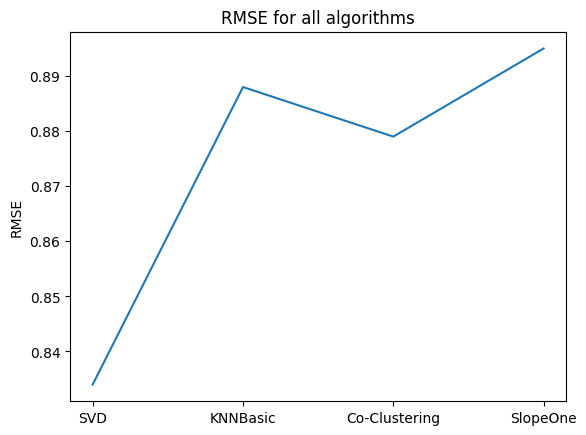

In [29]:
# plotting a graph for RMSE for all the algoeithms
# all_rmse = {"SVD": scores_svd['RMSE'], 'KNN Basic' : scores_knn_basic['RMSE'], 'Co-Clustering': scores_co_clustering['RMSE'], 'SlopeOne': scores_slope_one['RMSE']}
g = sns.lineplot(data = overall_scores['RMSE'], sort = True).set(title='RMSE for all algorithms')

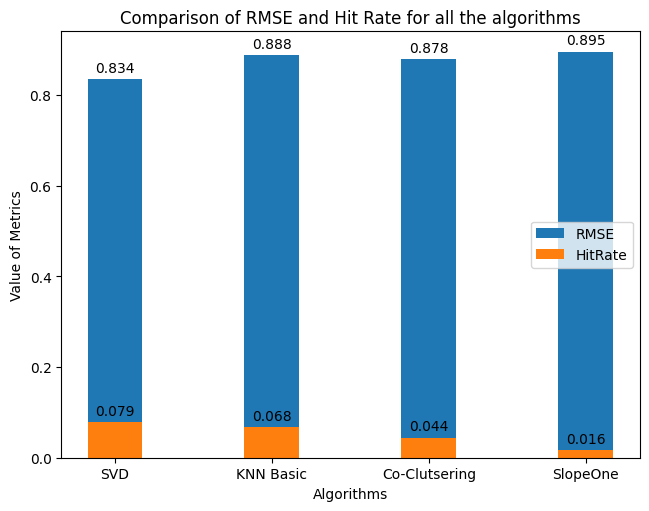

In [31]:
# # all_rmse = {"SVD": scores_svd['RMSE'], 'KNN Basic' : scores_knn_basic['RMSE'], 'Co-Clustering': scores_co_clustering['RMSE'], 'SlopeOne': scores_slope_one['RMSE']}
# g = sns.barplot(data = f).set(title='RMSE for all algorithms')
# comparing RMSE and Hit Rate for each algorithm with help of a bar graph
labels = ['SVD', 'KNN Basic', 'Co-Clutsering', 'SlopeOne']
fig, ax = plt.subplots()
x = np.arange(len(labels))
width = 0.35
rects1 = ax.bar(labels, [0.834, 0.888, 0.878, 0.895], width=0.35, label='RMSE')
rects2 = ax.bar(labels, [0.079, 0.068, 0.044, 0.016], width=0.35,label='HitRate')
fig.tight_layout()
ax.legend()
# setting legends and labels
plt.legend(loc='right')
plt.title('Comparison of RMSE and Hit Rate for all the algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Value of Metrics')
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
plt.show()

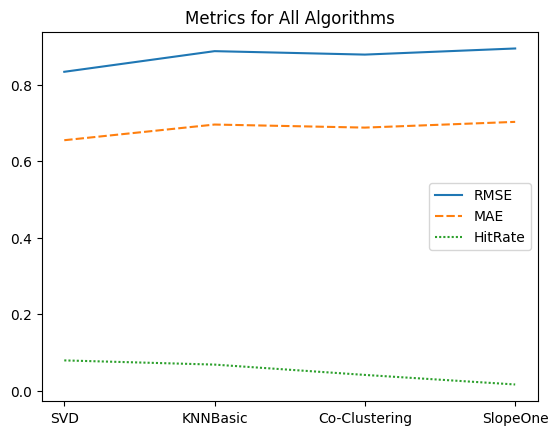

In [32]:
# legend = ['SVD', 'KNN Basic', 'Co-Clutsering', 'SlopeOne']
# comparing all the metrics for all the algorithms.  
g1 = sns.lineplot(data=overall_scores).set(title='Metrics for All Algorithms')
# g = g.set(xlim=(5,15))
# g.set(title = 'RMSE for top-N predictions for all algorithms')
plt.show(g1)